### Business objective and data

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. The **business objective** is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :
- The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.
- The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)
- The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

The data dictionary contains meanings of abbreviations. Some frequent ones are loc (local), IC (incoming), OG (outgoing), T2T (telecom operator to telecom operator), T2O (telecom operator to another operator), RECH (recharge) etc.

#### Data Preparation
- Derive new features
- Filter high-value customers - predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
- Tag churners and remove attributes of the churn phase - Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9
- After tagging churners, remove all the attributes corresponding to the churn phase

#### Modelling
Build models to predict churn. The predictive model that you’re going to build will serve two purposes:
- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

In some cases, both of the above-stated goals can be achieved by a single machine learning model. But here, you have a large number of attributes, and thus you should try using a dimensionality reduction technique such as PCA and then build a predictive model. After PCA, you can use any classification model. 

Also, since the rate of churn is typically low (about 5-10%, this is called class-imbalance) - try using techniques to handle class imbalance. 

In [3]:
#import necessary libraries

import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fancyimpute import KNN
pd.set_option('display.max_columns', None)

In [4]:
#import the dataset
df = pd.read_csv('telecom_churn_data.csv')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [5]:
#check shape of the dataframe
df.shape

(99999, 226)

In [6]:
#find out all recharge related columns
rech_cols = []

for cols in list(df.columns):
    if 'rech' in cols:
        rech_cols.append(cols)
        
rech_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_num_9',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'max_rech_amt_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9']

In [7]:
#Replace missing values in recharge column with zero
rech_cols = ['count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7']
df[rech_cols] = df[rech_cols].fillna(0)

In [8]:
#High-value customers - Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

#Let's find out high-value customers
df['av_rech_amt_data'] = ((df['count_rech_2g_6']+df['count_rech_3g_6'])*df['av_rech_amt_data_6'] + (df['count_rech_2g_7']+df['count_rech_3g_7'])*df['av_rech_amt_data_7'])/2 

df['av_rech_amt'] = (df['total_rech_amt_6'].fillna(0)+df['total_rech_amt_7'].fillna(0))/2

df['av_rech']=df['av_rech_amt_data']+df['av_rech_amt']

print('70 percentile is', df['av_rech'].quantile(0.7))

df = df[df['av_rech'] > df['av_rech'].quantile(0.7)]

#lets drop above used columns
df.drop(['count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7'], inplace=True, axis=1)

df.shape

70 percentile is 478.0


(29953, 223)

### Handling Missing values

In [9]:
#check missing values in each column
df_null = ((df.isnull().sum()*100/df.shape[0]).to_frame('null percent')).sort_values(by = 'null percent', ascending=False)
df_null

,null percent
fb_user_9,49.253831
max_rech_data_9,49.253831
arpu_3g_9,49.253831
date_of_last_rech_data_9,49.253831
total_rech_data_9,49.253831
...,...
max_rech_amt_7,0.000000
max_rech_amt_6,0.000000
total_rech_amt_9,0.000000
total_rech_amt_8,0.000000


In [10]:
#drop those columns where missing values are more than 30%

null_cols = list(df_null.index[df_null['null percent'] > 30])

print('List of columns dropped', null_cols)

df.drop(null_cols, axis=1, inplace=True)

List of columns dropped ['fb_user_9', 'max_rech_data_9', 'arpu_3g_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'arpu_2g_9', 'av_rech_amt_data_9', 'night_pck_user_9', 'count_rech_3g_9', 'count_rech_2g_9', 'date_of_last_rech_data_8', 'total_rech_data_8', 'night_pck_user_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_2g_8', 'arpu_3g_8', 'fb_user_8', 'arpu_3g_6', 'max_rech_data_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_6', 'total_rech_data_6', 'arpu_2g_6', 'date_of_last_rech_data_7', 'night_pck_user_7', 'arpu_3g_7', 'fb_user_7', 'max_rech_data_7', 'arpu_2g_7', 'total_rech_data_7']


In [11]:
#check the columns with no variance in their value and drop such columns

for col in df.columns:
    if df[col].nunique() == 1:
        print('\nColumn', col, ' does not have variance and contains only one unique value')
        df.drop(col, axis=1, inplace=True)


Column circle_id  does not have variance and contains only one unique value

Column loc_og_t2o_mou  does not have variance and contains only one unique value

Column std_og_t2o_mou  does not have variance and contains only one unique value

Column loc_ic_t2o_mou  does not have variance and contains only one unique value

Column last_date_of_month_6  does not have variance and contains only one unique value

Column last_date_of_month_7  does not have variance and contains only one unique value

Column last_date_of_month_8  does not have variance and contains only one unique value

Column last_date_of_month_9  does not have variance and contains only one unique value

Column std_og_t2c_mou_6  does not have variance and contains only one unique value

Column std_og_t2c_mou_7  does not have variance and contains only one unique value

Column std_og_t2c_mou_8  does not have variance and contains only one unique value

Column std_og_t2c_mou_9  does not have variance and contains only one un

In [12]:
#delete date columns as we will not use them for our analysis

date_cols = [col for col in df.columns if 'date' in col]
print('Date columns are', date_cols)
df.drop(date_cols, axis=1, inplace=True)

Date columns are ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']


In [13]:
#check missing values in each column
df_null = ((df.isnull().sum()*100/df.shape[0]).to_frame('null percent')).sort_values(by = 'null percent', ascending=False)
df_null.index[df_null['null percent'] > 0]

Index(['loc_ic_t2f_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2t_mou_9',
       'loc_og_t2c_mou_9', 'loc_og_mou_9', 'loc_ic_mou_9', 'std_og_t2t_mou_9',
       ...
       'isd_og_mou_7', 'std_og_mou_7', 'std_ic_t2t_mou_7', 'spl_og_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'std_og_t2m_mou_7',
       'loc_ic_mou_7', 'std_og_t2t_mou_7', 'loc_og_mou_7'],
      dtype='object', length=108)

In [14]:
#dropping rows with missing values
null_cols = list(df_null.index[df_null['null percent'] > 0])

for col in null_cols:
    print('Dropping row where missing value is found in column ', col)
    df = df[~np.isnan(df[col])]
    
df.shape

Dropping row where missing value is found in column  loc_ic_t2f_mou_9
Dropping row where missing value is found in column  roam_og_mou_9
Dropping row where missing value is found in column  loc_og_t2t_mou_9
Dropping row where missing value is found in column  loc_og_t2m_mou_9
Dropping row where missing value is found in column  std_ic_t2m_mou_9
Dropping row where missing value is found in column  std_ic_t2t_mou_9
Dropping row where missing value is found in column  loc_og_t2c_mou_9
Dropping row where missing value is found in column  loc_og_mou_9
Dropping row where missing value is found in column  loc_ic_mou_9
Dropping row where missing value is found in column  std_og_t2t_mou_9
Dropping row where missing value is found in column  std_og_t2m_mou_9
Dropping row where missing value is found in column  loc_ic_t2m_mou_9
Dropping row where missing value is found in column  std_og_t2f_mou_9
Dropping row where missing value is found in column  std_og_mou_9
Dropping row where missing value is

(27587, 169)

In [15]:
#check missing values in each column
df_null = ((df.isnull().sum()*100/df.shape[0]).to_frame('null percent')).sort_values(by = 'null percent', ascending=False)
df_null.head()

,null percent
mobile_number,0.0
isd_ic_mou_9,0.0
total_ic_mou_9,0.0
spl_ic_mou_6,0.0
spl_ic_mou_7,0.0


In [16]:
#lets introduce new column 'churn', it will take values either 1 or 0
#we will calculate churn/non-churn based on 4 columns - total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9

df['churn'] = np.where(df[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)==0, 1, 0)
df.head(5)

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,av_rech_amt_data,av_rech_amt,av_rech,churn
8,7001524846,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,80.63,136.48,108.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.13,217.59,12.49,26.13,80.96,70.58,50.54,34.58,0.00,0.0,0.00,0.00,0.0,0.0,7.15,0.00,378.09,288.18,63.04,60.71,116.56,133.43,22.58,7.33,13.69,10.04,75.69,74.13,0.0,0.0,0.0,0.00,130.26,143.48,98.28,81.46,0.0,0.00,0.0,0.0,0.0,0.0,10.23,0.00,0.0,0.0,0.0,0.0,508.36,431.66,171.56,142.18,23.84,9.84,0.31,4.03,57.58,13.98,15.48,17.34,0.00,0.00,0.00,0.00,81.43,23.83,15.79,21.38,0.00,0.58,0.10,0.00,22.43,4.08,0.65,13.53,0.00,0.00,0.00,0.00,22.43,4.66,0.75,13.53,103.86,28.49,16.54,34.91,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,15,437,601,120,186,90,154,30,36,50,0,10,0,0.00,356.00,0.03,0.00,0.0,750.95,11.94,0.00,0,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,315,21.03,910.65,122.16,0.0,177.0,519.0,696.0,0
21,7002124215,514.453,597.753,637.760,578.596,102.41,132.11,85.14,161.63,757.93,896.68,983.39,869.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.48,6.16,23.34,29.98,91.81,87.93,104.81,107.54,0.75,0.0,1.58,0.00,0.0,0.0,0.00,0.00,97.04,94.09,129.74,137.53,97.93,125.94,61.79,131.64,665.36,808.74,876.99,762.34,0.0,0.0,0.0,0.00,763.29,934.69,938.79,893.99,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,860.34,1028.79,1068.54,1031.53,2.48,10.19,19.54,17.99,118.23,74.63,129.16,113.46,4.61,2.84,10.39,8.41,125.33,87.68,159.11,139.88,14.06,5.98,0.18,16.74,67.69,38.23,101.74,95.98,0.00,0.00,0.00,0.00,81.76,44.21,101.93,112.73,207.09,131.89,261.04,252.61,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22,26,27,17,600,680,718,680

In [17]:
#will delete all attributes related to churn phase

churn_cols = [col for col in df.columns if '_9' in col]

df.drop(churn_cols, axis=1, inplace=True)

In [18]:
# Dropping sep_vbc_3g column
df = df.drop('sep_vbc_3g', axis=1)

In [19]:
df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,av_rech_amt_data,av_rech_amt,av_rech,churn
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.0,0.0,0.0,0.0,0.0,0.0,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.0,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.00,0.0,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.00,356.00,0.03,0.0,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,177.0,519.0,696.0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.0,0.0,0.0,0.0,0.0,0.0,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.0,1.58,0.0,0.0,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.0,0.0,0.0,763.29,934.69,938.79,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,860.34,1028.79,1068.54,2.48,10.19,19.54,118.23,74.63,129.16,4.61,2.84,10.39,125.33,87.68,159.11,14.06,5.98,0.18,67.69,38.23,101.74,0.00,0.00,0.00,81.76,44.21,101.93,207.09,131.89,261.04,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,22,26,27,600,680,718,50,50,50,30,20,50,0.00,0.00,0.00,0.0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,720,0.00,0.00,0.00,0.0,640.0,640.0,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.0,0.0,0.0,0.0,0.0,0.0,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.0,0.00,0.0,0.0,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.0,0.0,0.0,2.36,6.35,39.61,0.0,0.01,0.0,0.1,0.0,17.71,0.0,0.0,0.0,134.38,140.04,239.48,20.71,61.04,76.64,95.91,113.36,146.84,0.00,0.00,0.71,116.63,174.41,224.21,0.51,0.00,13.38,2.43,14.89,43.91,0.00,0.00,0.00,2.94,14.89,57.29,119.58,222.89,298.33,0.0,0.0,0.0,0.0,28.23,3.74,0.00,5.35,13.06,3,5,4,0,454,439,0,179,179,0,179,0,0.00,0.48,0.01,0.0,599.09,1009.92,0,0,0,0,0,0,0,2,1,0,0,1,604,40.45,51.86,0.00,356.0,227.0,583.0,0
33,7000149764,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0

In the filtered dataset, **mobile_number** and **churn** columns non-numeric, rest all are of numeric type.

In [20]:
df['mobile_number'] = df['mobile_number'].astype(object)
df['churn'] = df['churn'].astype(object)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27587 entries, 8 to 99997
Columns: 129 entries, mobile_number to churn
dtypes: float64(102), int64(25), object(2)
memory usage: 27.4+ MB


In [22]:
#check descriptive statistics for the dataset
df.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,av_rech_amt_data,av_rech_amt,av_rech
count,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.00000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000
mean,559.584952,569.761895,533.287648,264.387640,275.986476,248.995150,378.644503,388.712118,355.741951,16.259634,12.870417,13.155062,26.686726,20.226299,20.749388,87.759529,90.017614,83.695422,169.082665,170.299578,162.197385,6.599848,6.730866,6.276224,1.597445,1.902498,1.781004,263.450546,267.056725,252.177361,166.211297,178.060193,157.326063,178.248772,190.742535,166.328822,1.861355,1.907963,1.692112,346.325234,370.714508,325.350531,1.959077,1.970431,1.942657,5.826259,7.208723,6.890024,0.665151,0.031910,0.049888,618.2

In [23]:
df['churn'].value_counts(normalize=True)

0    0.972632
1    0.027368
Name: churn, dtype: float64

### Deriving new features

- Deriving column decrease_vbc

It indicates whether volume based cost of the customer is decreased or not in the action phase than good phase

In [24]:
df['diff_vbc'] = df['aug_vbc_3g'] - (df['jun_vbc_3g'] + df['jul_vbc_3g'])/2

df['decrease_vbc'] = np.where(df['diff_vbc'] < 0, 1, 0)

df.drop(['diff_vbc', 'aug_vbc_3g', 'jun_vbc_3g', 'jul_vbc_3g'], axis=1, inplace=True)

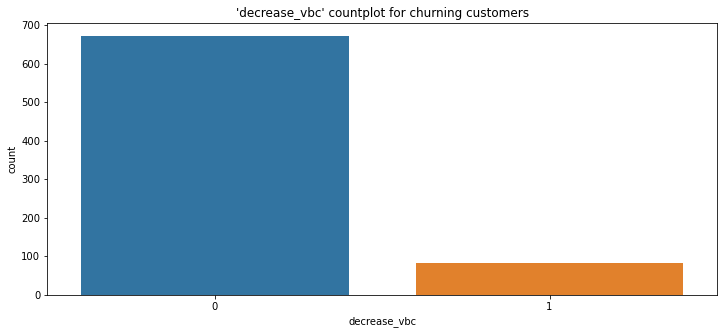

In [25]:
plt.figure(figsize=(12,5))
df_vbc = df[df['churn']==1]
sns.countplot(x=df_vbc['decrease_vbc'])
plt.title('\'decrease_vbc\' countplot for churning customers')
plt.show()

From the above graph, we can see that volume based cost is increased for churning customers

- Deriving column decrease_arpu

It indicates whether average revenue per customer is decreased or not in the action phase than good phase

In [26]:
df['diff_arpu'] = df['arpu_8'] - (df['arpu_6'] + df['arpu_7'])/2

df['decrease_arpu'] = np.where(df['diff_arpu'] < 0, 1, 0)

df.drop(['diff_arpu', 'arpu_6', 'arpu_7', 'arpu_8'], axis=1, inplace=True)

In [27]:
df[['decrease_arpu','churn']].value_counts()

decrease_arpu  churn
1              0        15200
0              0        11632
1              1          630
0              1          125
dtype: int64

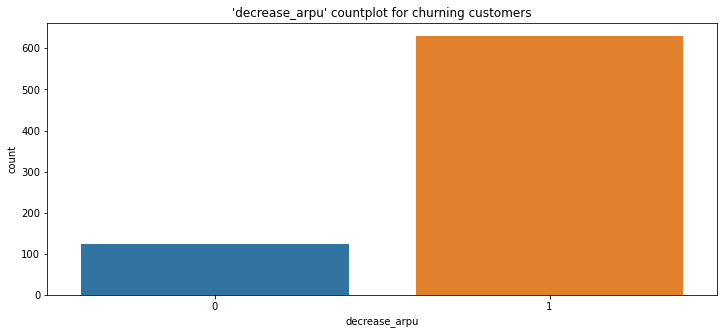

In [28]:
plt.figure(figsize=(12,5))
df_arpu = df[df['churn']==1]
sns.countplot(x=df_arpu['decrease_arpu'])
plt.title('\'decrease_arpu\' countplot for churning customers')
plt.show()

From the above graph, we can see that average revenue per customer is decreased for churning customers

- Deriving column decrease_mou

It indicates whether average minutes of usage has decreased or not in the action phase than good phase

In [29]:
df['diff_mou'] = df['total_og_mou_8'] + df['total_ic_mou_8'] - (df['total_og_mou_6'] + df['total_ic_mou_6'] + df['total_og_mou_7'] + df['total_ic_mou_7'])/2

df['decrease_mou'] = np.where(df['diff_mou'] < 0, 1, 0)

df.drop(['diff_mou', 'total_og_mou_8', 'total_og_mou_7', 'total_og_mou_6', 'total_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_6'], axis=1, inplace=True)

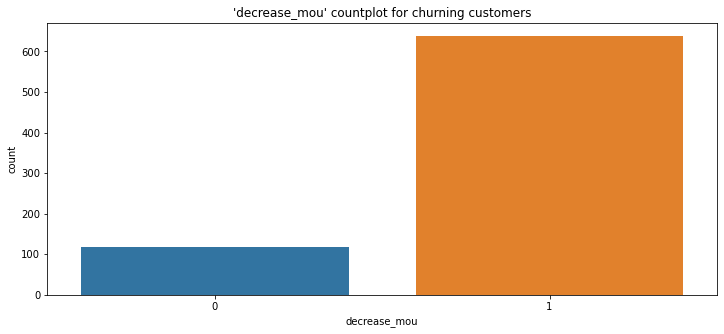

In [30]:
plt.figure(figsize=(12,5))
df_mou = df[df['churn']==1]
sns.countplot(x=df_mou['decrease_mou'])
plt.title('\'decrease_mou\' countplot for churning customers')
plt.show()

From the above graph, we can see that average minutes of usage per customer is decreased for churning customers

- Deriving column decrease_rech_num

It indicates whether number of recharge has decreased or not in the action phase than good phase

In [31]:
df['diff_rech_num'] = df['total_rech_num_8'] - (df['total_rech_num_6'] + df['total_rech_num_7'])/2

df['decrease_rech_num'] = np.where(df['diff_rech_num'] < 0, 1, 0)

df.drop(['diff_rech_num', 'total_rech_num_8', 'total_rech_num_6', 'total_rech_num_7'], axis=1, inplace=True)

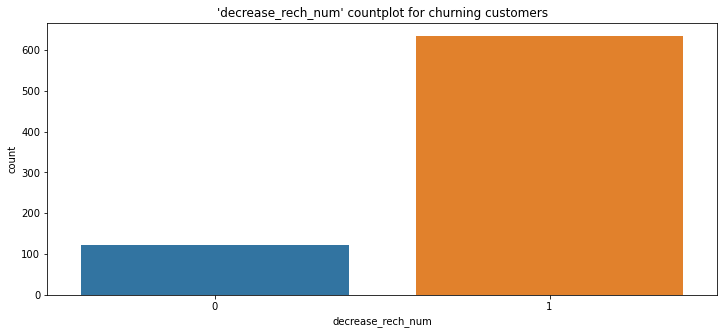

In [32]:
plt.figure(figsize=(12,5))
df_rech_num = df[df['churn']==1]
sns.countplot(x=df_rech_num['decrease_rech_num'])
plt.title('\'decrease_rech_num\' countplot for churning customers')
plt.show()

From the above graph, we can see that number of recharge per customer is decreased for churning customers

- Deriving column decrease_rech_amt

It indicates whether recharge amount has decreased or not in the action phase than good phase

In [33]:
df['diff_rech_amt'] = df['total_rech_amt_8'] - (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2

df['decrease_rech_amt'] = np.where(df['diff_rech_amt'] < 0, 1, 0)

df.drop(['diff_rech_amt', 'total_rech_amt_8', 'total_rech_amt_6', 'total_rech_amt_7'], axis=1, inplace=True)

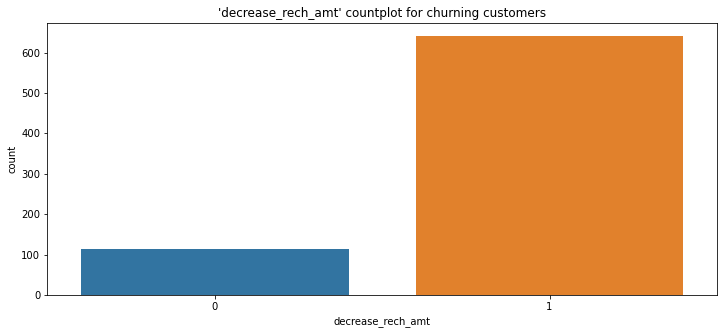

In [34]:
plt.figure(figsize=(12,5))
df_rech_amt = df[df['churn']==1]
sns.countplot(x=df_rech_amt['decrease_rech_amt'])
plt.title('\'decrease_rech_amt\' countplot for churning customers')
plt.show()

From the above graph, we can see that recharge amount per customer is decreased for churning customers

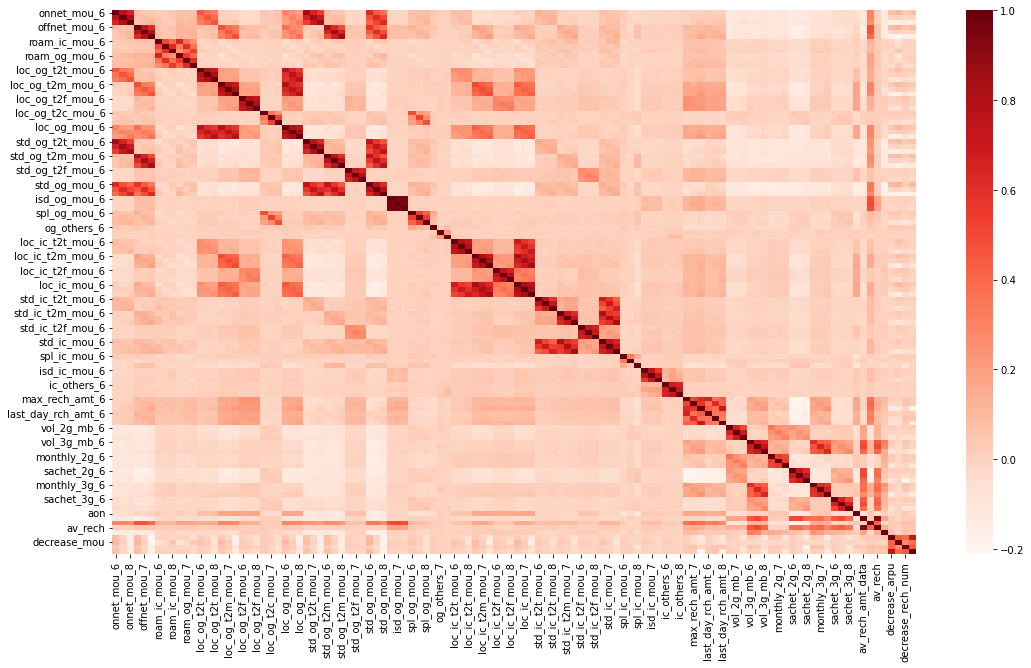

In [35]:
#heatmap

plt.figure(figsize=(18,10))
sns.heatmap(df.corr(), cmap='Reds')
plt.show()

### Train-test split

In [36]:
X = df.drop(['mobile_number', 'churn'], axis=1)
y = df['churn']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Feature Scaling

In [38]:
#remove categorical columns for scaling
cols_for_scale = list(X_train.columns)
cols_for_scale.remove('decrease_vbc')
cols_for_scale.remove('decrease_arpu')
cols_for_scale.remove('decrease_mou')
cols_for_scale.remove('decrease_rech_num')
cols_for_scale.remove('decrease_rech_amt')

In [39]:
#Instatiate StandardScaler and fit and transform the data
scaler = StandardScaler()
X_train[cols_for_scale] = scaler.fit_transform(X_train[cols_for_scale])
X_train.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,av_rech_amt_data,av_rech_amt,av_rech,decrease_vbc,decrease_arpu,decrease_mou,decrease_rech_num,decrease_rech_amt
98077,-0.547050,-0.541026,-0.470429,-0.487468,0.031332,0.032441,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,-0.307223,-0.295790,-0.245252,-0.214409,0.599232,0.671858,0.145171,1.269426,1.450867,-0.263327,-0.208693,-0.235933,-0.318266,0.264790,0.350337,-0.419491,-0.425994,-0.389503,-0.412265,-0.337194,-0.369565,0.042398,0.295495,0.157842,-0.553931,-0.502319,-0.499522,-0.039468,-0.039459,-0.039217,0.193801,0.197895,0.077337,0.502113,-0.017802,-0.016477,1.238947,1.837860,2.052032,1.162318,1.462353,1.929956,4.107727,3.858957,2.984635,2.057228,2.609145,2.839817,-0.206061,-0.194563,-0.212955,-0.224749,-0.241456,-0.166668,1.768927,2.355816,1.232447,-0.064362,0.004213,-0.073841,1.972627,-0.100933,-0.258988,-0.132624,-0.144417,-0.159418,0.637532,-0.073414,0.007411,-0.764295,-0.691563,-0.670411,-0.640546,-0.507917,-0.405312,-0.379072,-0.375940,-0.343156,-0.387729,-0.407640,-0.390697,-0.407689,-0.416941,-0.38877,-0.426525,-0.447617,-0.427174,-0.342977,-0.339765,-0.339066,-0.210186,-0.212511,-0.187843,0.115830,-0.406812,-0.334183,-0.502436,0,0,0,1,0
40036,-0.558659,-0.428208,-0.424887,-0.690393,-0.284953,-0.162317,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,-0.358713,-0.179916,-0.222529,-0.590738,0.029179,0.262786,-0.241106,0.076147,0.065486,-0.263327,0.321750,0.116709,-0.620389,-0.093334,0.029205,-0.402865,-0.365538,-0.340799,-0.393426,-0.315633,-0.301709,-0.155063,-0.051788,-0.149133,-0.534238,-0.455284,-0.427803,-0.039468,-0.039459,-0.039217,0.134819,-0.065940,-0.181489,-0.145780,-0.017802,-0.016477,0.135228,-0.143816,-0.088798,1.542861,1.935317,1.093087,0.090546,0.073181,-0.129262,1.145408,1.253800,0.694272,-0.203200,-0.194563,-0.154529,-0.000211,-0.266226,0.007172,-0.029493,-0.061396,-0.092143,-0.111656,-0.304362,-0.079937,2.121671,-0.100933,2.513470,-0.132624,-0.144417,-0.159418,-0.087648,0.088293,-0.098486,-0.081666,-0.101149,-0.206900,-0.356575,0.342713,-0.657848,-0.326766,-0.087207,-0.343156,-0.236005,-0.153312,-0.390697,1.888123,1.789120,-0.38877,-0.028463,-0.447617,-0.427174,-0.342977,-0.339765,-0.339066,0.835956,-0.212511,-0.187843,-0.835714,0.229549,0.039027,0.223628,1,1,1,1,1
85637,-0.395715,-0.376973,-0.361758,0.299433,0.261408,0.387599,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,-0.021027,-0.008209,-0.015942,1.157056,1.346100,1.397320,0.833327,0.457156,-0.16467

In [40]:
#transform data from test dataset
X_test[cols_for_scale] = scaler.transform(X_test[cols_for_scale])
X_test.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,av_rech_amt_data,av_rech_amt,av_rech,decrease_vbc,decrease_arpu,decrease_mou,decrease_rech_num,decrease_rech_amt
41280,-0.569647,-0.554468,-0.533050,-0.678729,-0.038397,-0.731637,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,-0.354357,-0.363246,-0.352181,-0.535028,0.671317,-0.678824,-0.308809,-0.286588,-0.308954,-0.263327,-0.141423,-0.235933,-0.584663,0.179019,-0.674116,-0.417950,-0.401316,-0.389503,-0.390728,-0.365505,-0.401791,-0.155063,-0.141770,-0.149133,-0.542434,-0.514515,-0.526680,-0.039468,-0.039459,-0.039217,-0.297519,-0.135766,-0.213201,-0.14578,-0.017802,-0.016477,-0.401966,-0.366423,-0.035038,1.280174,4.209864,1.944638,-0.301688,-0.327372,-0.226115,0.619336,2.620733,1.299853,-0.206061,0.533606,1.337007,3.683879,2.958838,5.764278,-0.163767,-0.157728,-0.145828,2.586070,2.392440,5.046676,-0.312716,-0.100933,-0.258988,-0.131998,-0.144417,-0.159418,-0.040133,-0.092819,-0.056127,-0.081666,0.159995,-0.067847,0.381748,-0.366146,0.393248,-0.281304,-0.37594,2.313487,1.094992,-0.407640,-0.267750,4.183936,-0.416941,2.023986,-0.426525,-0.447617,-0.427174,-0.342977,-0.339765,-0.339066,-0.210186,-0.212511,-0.187843,-0.978601,-0.150268,-0.386961,-0.291107,1,1,0,1,1
51831,-0.369352,-0.519979,-0.469223,-0.680575,-0.265461,-0.513738,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,0.042180,-0.255188,-0.226891,-0.454400,0.319586,-0.255669,-0.308809,0.009904,-0.072905,-0.263327,-0.208693,-0.235933,-0.293306,0.040327,-0.311635,-0.419491,-0.425994,-0.389503,-0.444021,-0.440923,-0.401791,-0.155063,-0.141770,-0.149133,-0.579206,-0.581924,-0.526680,-0.039468,-0.039459,-0.039217,-0.333595,-0.319611,-0.323260,-0.14578,-0.017802,-0.016477,-0.125583,-0.307275,-0.313233,-0.006375,0.444459,-0.291132,0.240011,1.027223,0.291983,-0.037356,0.300413,-0.323990,-0.198568,-0.194563,-0.212955,-0.278795,-0.298287,-0.193371,-0.124275,-0.127659,0.187237,-0.325892,-0.335307,-0.226587,-0.312716,-0.100933,-0.258988,-0.132624,-0.144417,-0.159418,-0.005082,-0.005203,-0.004691,-0.081666,-0.101149,-0.206900,-0.711538,-0.720575,-0.657848,0.262771,0.60102,-0.343156,-0.387729,-0.290324,-0.390697,1.888123,1.789120,-0.388770,-0.426525,-0.447617,-0.427174,-0.342977,-0.339765,-0.339066,-0.210186,-0.212511,-0.187843,1.646170,-0.278540,-0.629171,-0.504323,0,1,1,0,1
74908,-0.425202,-0.478051,-0.284534,1.601313,1.984643,1.521379,-0.216322,-0.165506,-0.169131,-0.229481,-0.210764,-0.191254,-0.075435,-0.177230,0.135644,2.944672,2.808002,3.175976,9.7

### Model with PCA

In [41]:
#instantiate PCA
pca = PCA(random_state=42)
#fit train set on PCA
pca.fit(X_train)
#Principal Components
pca.components_

array([[ 5.29778135e-02,  5.41384503e-02,  5.97591857e-02, ...,
        -4.33943486e-03,  2.64450482e-03, -7.75010027e-03],
       [ 1.92133920e-01,  2.10165998e-01,  2.00436475e-01, ...,
        -4.12988528e-03, -1.14235744e-02, -3.32876662e-03],
       [-1.01938352e-01, -1.04449375e-01, -9.12920098e-02, ...,
        -9.12542391e-03,  4.95105529e-03, -6.27553042e-03],
       ...,
       [ 1.10000223e-07, -2.79553142e-06,  2.86338595e-06, ...,
        -3.04150402e-07, -2.62206746e-07,  9.41887192e-08],
       [-1.38107411e-06, -4.34855121e-07, -5.24120133e-07, ...,
        -2.45315244e-07, -6.31538149e-08, -1.05259937e-07],
       [-0.00000000e+00,  6.15243752e-15, -3.11332846e-15, ...,
        -1.54228670e-17,  2.21586038e-16,  1.92514534e-16]])

In [42]:
#cumulative variance of principal components
variance_cum = np.cumsum(pca.explained_variance_ratio_)
print(variance_cum)

[0.09247995 0.17164272 0.22400125 0.26936572 0.31087621 0.34947039
 0.38055436 0.41014577 0.43929977 0.46686554 0.49257345 0.51765023
 0.54191921 0.56595124 0.58743543 0.60508209 0.62250867 0.63913717
 0.65445583 0.66966288 0.68370928 0.69664356 0.70929092 0.7205758
 0.73146727 0.74231867 0.75207109 0.76114802 0.76994127 0.77857579
 0.78680686 0.7945815  0.80230038 0.80985791 0.81710324 0.82417578
 0.83120364 0.8378063  0.84413329 0.85023216 0.85602637 0.86172932
 0.86733554 0.87278367 0.87768131 0.88230673 0.88672993 0.89109912
 0.89545126 0.89972637 0.9038592  0.90793002 0.91192973 0.91573239
 0.91948547 0.92317823 0.92648238 0.92976936 0.93292704 0.93599173
 0.93896179 0.94189444 0.94476963 0.94757708 0.95026821 0.9528982
 0.95547684 0.95792646 0.96034118 0.96265651 0.96495392 0.96720577
 0.9693589  0.97141321 0.97345616 0.97545643 0.97740513 0.97931486
 0.98115698 0.98294907 0.98464898 0.98634071 0.98796801 0.98939542
 0.99076667 0.9920981  0.99338149 0.99459321 0.99574435 0.996834

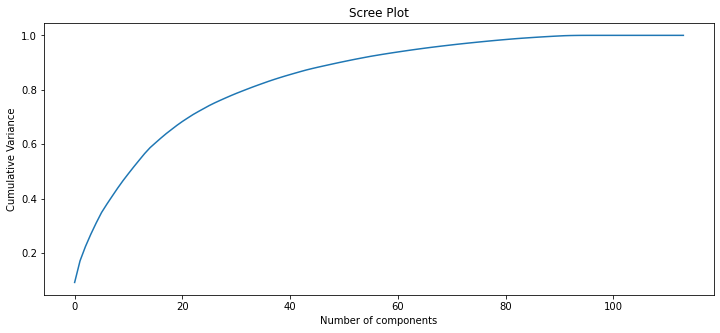

In [43]:
#scree plot 
plt.figure(figsize=(12,5))
plt.plot(variance_cum)
plt.xlabel('Number of components')
plt.ylabel('Cumulative Variance')
plt.title('Scree Plot')
plt.show()

From the above graph, we can see that 70 principal components can explain almost 95% variance present in the data, so we will go with 70 principal components

In [44]:
#Instantiate PCA with 70 components
pca_final = IncrementalPCA(n_components = 70)

#Fit and transform X_train
X_train_pca = pca_final.fit_transform(X_train)

#Applying transformation on the test set
X_test_pca = pca_final.transform(X_test)

**Here, we need to correctly identify churning customers, hence we will focus more on sensitivity/recall**

### Logistic Regression with PCA

In [45]:
lr = LogisticRegression(random_state=42, class_weight='balanced')

#specify parameters
params = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

#will specify score as recall in GridSearchCV
model_cv = GridSearchCV(estimator = lr, param_grid=params, verbose=1, n_jobs=-1, scoring='recall', cv=5, return_train_score=True, refit=True)

#fit the model
lr_model = model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [46]:
model_cv.best_score_, model_cv.best_params_

(0.8572649572649572, {'C': 0.1})

In [47]:
#prediction on the train set
y_pred = lr_model.predict(X_train_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_train, y_pred))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_train, y_pred))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_train, y_pred))

Accuracy- 0.8290815170601296
Recall- 0.8848797250859106
Precision- 0.12203791469194313


In [48]:
#prediction on the test set
y_pred_test = lr_model.predict(X_test_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_test, y_pred_test))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_test, y_pred_test))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_test, y_pred_test))

Accuracy- 0.8256614715476622
Recall- 0.8901734104046243
Precision- 0.14038286235186873


#### Results using Logistic Regression model
- Training Dataset
    - Accuracy - 0.82
    - Sensitivity - 0.88
    - Precision - 0.12
- Test Dataset
    - Accuracy - 0.82
    - Sensitivity - 0.89
    - Precision - 0.14

### Decision Tree Classifier Model

In [49]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

params = {
    'min_samples_leaf' : [50, 75, 100, 125, 150, 200, 250],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [50, 75, 100, 125, 150, 200, 250]
}

grid_search_tree = GridSearchCV(estimator=dt, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='recall', refit=True)

grid_search_tree.fit(X_train_pca, y_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [50, 75, 100, 125, 150, 200, 250],
                         'min_samples_split': [50, 75, 100, 125, 150, 200,
                                               250]},
             scoring='recall', verbose=1)

In [50]:
grid_search_tree.best_score_, grid_search_tree.best_estimator_

(0.8349101090480401,
 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                        min_samples_leaf=200, min_samples_split=50,
                        random_state=42))

In [51]:
lr_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5, min_samples_leaf=200, min_samples_split=50)
lr_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=200, min_samples_split=50,
                       random_state=42)

In [52]:
#prediction on the train set
y_pred = lr_model.predict(X_train_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_train, y_pred))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_train, y_pred))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_train, y_pred))

Accuracy- 0.7875300194843445
Recall- 0.8900343642611683
Precision- 0.10071942446043165


In [53]:
#prediction on the test set
y_pred_test = lr_model.predict(X_test_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_test, y_pred_test))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_test, y_pred_test))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_test, y_pred_test))

Accuracy- 0.7705690467560711
Recall- 0.8323699421965318
Precision- 0.10427226647356988


In [54]:
#fine tuning of hyper-parameters

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

params = {
    'min_samples_leaf' : [180, 190, 200, 210, 220],
    'max_depth' : [3, 4, 5, 6, 7],
    'min_samples_split' : [30, 40, 50, 60, 70]
}

grid_search_tree = GridSearchCV(estimator=dt, param_grid=params, n_jobs=-1, verbose=1, cv=5, scoring='recall', refit=True)

lr_model = grid_search_tree.fit(X_train_pca, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


In [55]:
grid_search_tree.best_score_, grid_search_tree.best_estimator_

(0.8349101090480401,
 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                        min_samples_leaf=200, min_samples_split=30,
                        random_state=42))

In [56]:
lr_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5, min_samples_leaf=220, min_samples_split=30)
lr_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=220, min_samples_split=30,
                       random_state=42)

In [57]:
#prediction on the train set
y_pred = lr_model.predict(X_train_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_train, y_pred))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_train, y_pred))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_train, y_pred))

Accuracy- 0.7774706602020934
Recall- 0.8951890034364262
Precision- 0.09700242040588344


In [58]:
#prediction on the test set
y_pred_test = lr_model.predict(X_test_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_test, y_pred_test))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_test, y_pred_test))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_test, y_pred_test))

Accuracy- 0.7649510692279812
Recall- 0.8439306358381503
Precision- 0.10310734463276836


#### Results using Decision Tree model
- Training Dataset
    - Accuracy - 0.78
    - Sensitivity - 0.90
    - Precision - 0.10
- Test Dataset
    - Accuracy - 0.76
    - Sensitivity - 0.84
    - Precision - 0.10

### Random Forest Classifier Model

In [59]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

params = {
    'max_depth' : [3, 6, 9],
    'n_estimators' : [50, 100, 150],
    'min_samples_split' : [30, 40, 50, 60],
    'min_samples_leaf' : [50, 75, 100],
    'max_features' : [10, 15, 20]
}

grid_search_rf = GridSearchCV(refit=True, n_jobs=-1, verbose=1, estimator=rf, param_grid=params, cv=3, scoring='recall')

grid_search_rf.fit(X_train_pca, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9], 'max_features': [10, 15, 20],
                         'min_samples_leaf': [50, 75, 100],
                         'min_samples_split': [30, 40, 50, 60],
                         'n_estimators': [50, 100, 150]},
             scoring='recall', verbose=1)

In [60]:
grid_search_rf.best_score_, grid_search_rf.best_estimator_

(0.7491408934707904,
 RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=10,
                        min_samples_leaf=50, min_samples_split=30,
                        n_estimators=50, random_state=42))

In [61]:
lr_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_features=20, max_depth=3, min_samples_leaf=75, min_samples_split=30)
lr_model.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=20,
                       min_samples_leaf=75, min_samples_split=30,
                       random_state=42)

In [62]:
#prediction on the train set
y_pred = lr_model.predict(X_train_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_train, y_pred))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_train, y_pred))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_train, y_pred))

Accuracy- 0.8587611581856903
Recall- 0.7989690721649485
Precision- 0.1341991341991342


In [63]:
#prediction on the test set
y_pred_test = lr_model.predict(X_test_pca)

#accuracy on the trained dataset
print('Accuracy-', metrics.accuracy_score(y_test, y_pred_test))

#recall score on the trained dataset
print('Recall-', metrics.recall_score(y_test, y_pred_test))

#precision score on the trained dataset
print('Precision-', metrics.precision_score(y_test, y_pred_test))

Accuracy- 0.8488582819862269
Recall- 0.7341040462427746
Precision- 0.13879781420765028


#### Results using Random Forest Tree model
- Training Dataset
    - Accuracy - 0.86
    - Sensitivity - 0.80
    - Precision - 0.13
- Test Dataset
    - Accuracy - 0.85
    - Sensitivity - 0.73
    - Precision - 0.14

From the above results, we can see that sensitivity and accuracy is more for Logistic Regression model with PCA, hence we will go ahead with this simple model rather than random forest or decision trees.

### Logistic Regression with no PCA

In [64]:
#Adding constant to X_train
X_train_sm = sm.add_constant(X_train)
#Instantiate logistic regression model
log_reg = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())

In [65]:
log_reg = log_reg.fit()

log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                22069
Model:                            GLM   Df Residuals:                    21955
Model Family:                Binomial   Df Model:                          113
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 02 Aug 2022   Deviance:                       61433.
Time:                        07:06:32   Pearson chi2:                 3.00e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.472e+14   1.09e+06  -5.94e+08      0.000   -6.47e+14   -6.47e+14
onnet_mou_6          6.57e+14   5.03e+07   1.31e+07      0.000    6.57e+14    6.57e+14
onnet_mou_7         7.464e+14   3.66e+07   2.04e+07      0.000    7.46e+14    7.46e+14
onnet_mou_8        -4.969e+14   3.04e+07  -1.63e+07      0.000   -4.97e+14   -4.97e+14
offnet_mou_6        5.667e+14   5.27e+07   1.08e+07      0.000    5.67e+14    5.67e+14
offnet_mou_7        6.148e+14   3.65e+07   1.69e+07      0.000    6.15e+14    6.15e+14
offnet_mou_8       -3.363e+14   3.05e+07   -1.1e+07      0.000   -3.36e+14   -3.36e+14
roam_ic_mou_6        2.01e+13    7.2e+05   2.79e+07      0.000    2.01e+13    2.01e+13
roam_ic_mou_7      -4.381e+12   7.87e+05  -5.57e+06      0.000   -4.38e+12   -4.38e+12
roam_ic_mou_8       3.843e+13   7.07e+05   5.44e+07      0.000    3.84e+13    3.84e+13
roam_og_mou_6      -1.664e+14   1.29e+07  -1.29e+07      0.000   -1.66e+14   -1.66e+14
roam_og_mou_7      -3.441e+13   6.99e+06  -4.92e+06      0.000   -3.44e+13   -3.44e+13
roam_og_mou_8       1.352e+13   6.84e+06   1.98e+06      0.000    1.35e+13    1.35e+13
loc_og_t2t_mou_6   -2.839e+17   1.81e+10  -1.57e+07      0.000   -2.84e+17   -2.84e+17
loc_og_t2t_mou_7   -3.358e+17   1.96e+10  -1.71e+07      0.000   -3.36e+17   -3.36e+17
loc_og_t2t_mou_8    6.641e+16    1.9e+10   3.49e+06      0.000    6.64e+16    6.64e+16
loc_og_t2m_mou_6   -3.137e+17      2e+10  -1.57e+07      0.000   -3.14e+17   -3.14e+17
loc_og_t2m_mou_7   -3.326e+17   1.94e+10  -1.71e+07      0.000   -3.33e+17   -3.33e+17
loc_og_t2m_mou_8    6.621e+16    1.9e+10   3.48e+06      0.000    6.62e+16    6.62e+16
loc_og_t2f_mou_6   -2.668e+16    1.7e+09  -1.57e+07      0.000   -2.67e+16   -2.67e+16
loc_og_t2f_mou_7   -2.946e+16   1.72e+09  -1.71e+07      0.000   -2.95e+16   -2.95e+16
loc_og_t2f_mou_8    5.516e+15   1.61e+09   3.43e+06      0.000    5.52e+15    5.52e+15
loc_og_t2c_mou_6    -8.92e+12   5.61e+05  -1.59e+07      0.000   -8.92e+12   -8.92e+12
loc_og_t2c_mou_7   -8.726e+12   6.51e+05  -1.34e+07      0.000   -8.73e+12   -8.73e+12
loc_og_t2c_mou_8    1.347e+13   6.06e+05   2.22e+07      0.000    1.35e+13    1.35e+13
loc_og_mou_6        4.727e+17   3.01e+10   1.57e+07      0.000    4.73e+17    4.73e+17
loc_og_mou_7        5.185e+17   3.03e+10   1.71e+07      0.000    5.19e+17    5.19e+17
loc_og_mou_8       -1.038e+17   2.98e+10  -3.48e+06      0.000   -1.04e+17   -1.04e+17
std_og_t2t_mou_6   -4.063e+17   4.03e+10  -1.01e+07      0.000   -4.06e+17   -4.06e+17
std_og_t2t_mou_7   -8.502e+17   4.35e+10  -1.95e+07      0.000    -8.5e+17    -8.5e+17
std_og_t2t_mou_8    4.174e+17   4.28e+10   9.74e+06      0.000    4.17e+17    4.17e+17
std_og_t2m_mou_6   -4.108e+17   4.08e+10  -1.01e+07      0.000   -4.11e+17   -4.11e+17
std_og_t2m_mou_7   -8.789e+17    4.5e+

We can see that many features have higher p-values, hence we will eliminate them using RFE.

In [66]:
#Instantiate Logistic Regression model
lr = LogisticRegression(random_state=42)

#Instantiate RFE with 15 columns
rfe = RFE(lr, 15)

#Fit the RFE model with train set
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=15)

In [67]:
#RFE selected columns
rfe_cols = X_train.columns[rfe.support_]
rfe_cols

Index(['onnet_mou_8', 'loc_og_t2f_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8',
       'isd_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8', 'ic_others_8',
       'sachet_2g_8', 'monthly_3g_8', 'decrease_vbc', 'decrease_mou'],
      dtype='object')

### Model 1 - with RFE selected 15 columns

In [68]:
#Adding constant to X_train
X_train_sm = sm.add_constant(X_train[rfe_cols])
#Instantiate logistic regression model
log_reg = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
#fit the model
log_reg = log_reg.fit()
#display summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                22069
Model:                            GLM   Df Residuals:                    22053
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1908.5
Date:                Tue, 02 Aug 2022   Deviance:                       3817.1
Time:                        07:07:12   Pearson chi2:                 3.06e+05
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.0297      0.239    -29.355      0.000      -7.499      -6.560
onnet_mou_8          1.2950      0.195      6.626      0.000       0.912       1.678
loc_og_t2f_mou_8    -0.8014      0.369     -2.174      0.030      -1.524      -0.079
loc_og_mou_8        -1.2183      0.203     -5.988      0.000      -1.617      -0.820
std_og_t2t_mou_8    -1.2375      0.177     -7.002      0.000      -1.584      -0.891
isd_og_mou_8        -2.6935      1.872     -1.439      0.150      -6.363       0.976
loc_ic_t2t_mou_8  1.149e+04   1474.694      7.792      0.000    8599.761    1.44e+04
loc_ic_t2m_mou_8  1.527e+04   1960.340      7.791      0.000    1.14e+04    1.91e+04
loc_ic_t2f_mou_8  3148.8639    404.264      7.789      0.000    2356.522    3941.206
loc_ic_mou_8       -2.2e+04   2822.618     -7.793      0.000   -2.75e+04   -1.65e+04
spl_ic_mou_8        -0.9130      0.218     -4.182      0.000      -1.341      -0.485
ic_others_8         -2.7059      1.065     -2.540      0.011      -4.794      -0.618
sachet_2g_8         -0.9649      0.129     -7.472      0.000      -1.218      -0.712
monthly_3g_8        -0.9279      0.153     -6.084      0.000      -1.227      -0.629
decrease_vbc        -0.8687      0.147     -5.912      0.000      -1.157      -0.581
decrease_mou         0.8905      0.128      6.957      0.000       0.640       1.141
====================================================================================
"""

### Checking VIF's

In [69]:
#creating dataframe to contain variable name and their VIF values
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
8,loc_ic_mou_8,2.528302e+09
6,loc_ic_t2m_mou_8,1.219458e+09
5,loc_ic_t2t_mou_8,6.900780e+08
7,loc_ic_t2f_mou_8,5.184461e+07
0,onnet_mou_8,9.520000e+00
3,std_og_t2t_mou_8,8.260000e+00
2,loc_og_mou_8,3.160000e+00
1,loc_og_t2f_mou_8,1.190000e+00
14,decrease_mou,1.170000e+00
13,decrease_vbc,1.160000e+00


In [70]:
#removing column 'loc_ic_mou_8' from RFE Selected columns
rfe_cols = rfe_cols.to_list()
rfe_cols.remove('loc_ic_mou_8')
rfe_cols

['onnet_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'isd_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'spl_ic_mou_8',
 'ic_others_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'decrease_vbc',
 'decrease_mou']

### Model 2 - after removing 'loc_ic_mou_8' variable

In [71]:
#Adding constant to X_train
X_train_sm = sm.add_constant(X_train[rfe_cols])
#Instantiate logistic regression model
log_reg = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
#fit the model
log_reg = log_reg.fit()
#display summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                22069
Model:                            GLM   Df Residuals:                    22054
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1941.1
Date:                Tue, 02 Aug 2022   Deviance:                       3882.3
Time:                        07:07:12   Pearson chi2:                 6.71e+05
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.5158      0.254    -29.554      0.000      -8.014      -7.017
onnet_mou_8          1.3823      0.198      6.991      0.000       0.995       1.770
loc_og_t2f_mou_8    -0.9994      0.393     -2.541      0.011      -1.770      -0.228
loc_og_mou_8        -1.3159      0.212     -6.217      0.000      -1.731      -0.901
std_og_t2t_mou_8    -1.3513      0.179     -7.545      0.000      -1.702      -1.000
isd_og_mou_8        -2.6228      1.871     -1.402      0.161      -6.291       1.045
loc_ic_t2t_mou_8    -1.6399      0.399     -4.110      0.000      -2.422      -0.858
loc_ic_t2m_mou_8    -2.3499      0.317     -7.425      0.000      -2.970      -1.730
loc_ic_t2f_mou_8    -1.5520      0.454     -3.420      0.001      -2.442      -0.663
spl_ic_mou_8        -0.9419      0.219     -4.300      0.000      -1.371      -0.513
ic_others_8         -3.0349      1.117     -2.718      0.007      -5.224      -0.846
sachet_2g_8         -1.0003      0.129     -7.732      0.000      -1.254      -0.747
monthly_3g_8        -0.9392      0.153     -6.151      0.000      -1.238      -0.640
decrease_vbc        -0.8745      0.146     -5.979      0.000      -1.161      -0.588
decrease_mou         0.9006      0.127      7.089      0.000       0.652       1.150
====================================================================================
"""

In [72]:
#creating dataframe to contain variable name and their VIF values
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
0,onnet_mou_8,9.51
3,std_og_t2t_mou_8,8.25
2,loc_og_mou_8,3.14
6,loc_ic_t2m_mou_8,1.41
1,loc_og_t2f_mou_8,1.19
13,decrease_mou,1.17
7,loc_ic_t2f_mou_8,1.16
12,decrease_vbc,1.16
5,loc_ic_t2t_mou_8,1.12
10,sachet_2g_8,1.03


### Model 3 after removing 'onnet_mou_8' variable

In [73]:
#removing 'decrease_rech_amt' variable because og high VIF values
rfe_cols.remove('onnet_mou_8')

#Adding constant to X_train
X_train_sm = sm.add_constant(X_train[rfe_cols])
#Instantiate logistic regression model
log_reg = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
#fit the model
log_reg = log_reg.fit()
#display summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                22069
Model:                            GLM   Df Residuals:                    22055
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1968.7
Date:                Tue, 02 Aug 2022   Deviance:                       3937.4
Time:                        07:07:13   Pearson chi2:                 1.21e+06
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.5278      0.255    -29.540      0.000      -8.027      -7.028
loc_og_t2f_mou_8    -1.0997      0.393     -2.797      0.005      -1.870      -0.329
loc_og_mou_8        -0.6834      0.219     -3.127      0.002      -1.112      -0.255
std_og_t2t_mou_8    -0.1550      0.054     -2.884      0.004      -0.260      -0.050
isd_og_mou_8        -2.5940      1.877     -1.382      0.167      -6.273       1.085
loc_ic_t2t_mou_8    -1.4484      0.391     -3.701      0.000      -2.216      -0.681
loc_ic_t2m_mou_8    -2.7960      0.325     -8.602      0.000      -3.433      -2.159
loc_ic_t2f_mou_8    -1.5907      0.458     -3.470      0.001      -2.489      -0.692
spl_ic_mou_8        -0.9738      0.221     -4.403      0.000      -1.407      -0.540
ic_others_8         -3.0976      1.121     -2.763      0.006      -5.295      -0.900
sachet_2g_8         -1.0130      0.129     -7.858      0.000      -1.266      -0.760
monthly_3g_8        -0.9330      0.151     -6.196      0.000      -1.228      -0.638
decrease_vbc        -0.8837      0.146     -6.069      0.000      -1.169      -0.598
decrease_mou         0.8485      0.125      6.803      0.000       0.604       1.093
====================================================================================
"""

In [74]:
#creating dataframe to contain variable name and their VIF values
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,loc_og_mou_8,1.30
5,loc_ic_t2m_mou_8,1.27
12,decrease_mou,1.17
0,loc_og_t2f_mou_8,1.16
6,loc_ic_t2f_mou_8,1.16
11,decrease_vbc,1.16
4,loc_ic_t2t_mou_8,1.10
2,std_og_t2t_mou_8,1.04
9,sachet_2g_8,1.03
10,monthly_3g_8,1.03


In [75]:
#for 'isd_og_mou_8' variable, p-value is higher than 0.005, hence we will remove it
rfe_cols.remove('isd_og_mou_8')

#Adding constant to X_train
X_train_sm = sm.add_constant(X_train[rfe_cols])
#Instantiate logistic regression model
log_reg = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
#fit the model
log_reg = log_reg.fit()
#display summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                22069
Model:                            GLM   Df Residuals:                    22056
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1973.7
Date:                Tue, 02 Aug 2022   Deviance:                       3947.4
Time:                        07:07:13   Pearson chi2:                 1.21e+06
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.4705      0.248    -30.095      0.000      -7.957      -6.984
loc_og_t2f_mou_8    -1.1399      0.396     -2.880      0.004      -1.916      -0.364
loc_og_mou_8        -0.6767      0.218     -3.104      0.002      -1.104      -0.249
std_og_t2t_mou_8    -0.1491      0.054     -2.785      0.005      -0.254      -0.044
loc_ic_t2t_mou_8    -1.4652      0.392     -3.740      0.000      -2.233      -0.697
loc_ic_t2m_mou_8    -2.7901      0.325     -8.592      0.000      -3.427      -2.154
loc_ic_t2f_mou_8    -1.6149      0.461     -3.506      0.000      -2.518      -0.712
spl_ic_mou_8        -0.9750      0.221     -4.411      0.000      -1.408      -0.542
ic_others_8         -3.1549      1.123     -2.809      0.005      -5.356      -0.954
sachet_2g_8         -1.0051      0.129     -7.815      0.000      -1.257      -0.753
monthly_3g_8        -0.9317      0.150     -6.191      0.000      -1.227      -0.637
decrease_vbc        -0.8781      0.146     -6.032      0.000      -1.163      -0.593
decrease_mou         0.8617      0.125      6.917      0.000       0.617       1.106
====================================================================================
"""

### Creating dataframe with actual churn and predicted probabilities

In [76]:
y_pred_train_final = pd.DataFrame({
    'custid' : X_train.index,
    'churn' : y_train.values,
    'churn_prob' : log_reg.predict(X_train_sm)
})

y_pred_train_final.head()

,custid,churn,churn_prob
98077,98077,0,4.418596e-10
40036,40036,0,8.840676e-06
85637,85637,0,2.487922e-05
9533,9533,0,1.672677e-02
27502,27502,0,8.129265e-04


### Finding optimal probability cutoff point

In [77]:
prob_thresh = [(i/10) for i in range(10)]

for i in prob_thresh:
    y_pred_train_final[i] = y_pred_train_final['churn_prob'].map(lambda x: 1 if x > i else 0) 
    
y_pred_train_final.head()

,custid,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
98077,98077,0,4.418596e-10,1,0,0,0,0,0,0,0,0,0
40036,40036,0,8.840676e-06,1,0,0,0,0,0,0,0,0,0
85637,85637,0,2.487922e-05,1,0,0,0,0,0,0,0,0,0
9533,9533,0,1.672677e-02,1,0,0,0,0,0,0,0,0,0
27502,27502,0,8.129265e-04,1,0,0,0,0,0,0,0,0,0


In [78]:
cutoff_df = pd.DataFrame(columns = ['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in prob_thresh:
    conf = metrics.confusion_matrix(y_pred_train_final['churn'], y_pred_train_final[i])
    total = conf[0,0] + conf[0,1] + conf[1,0] + conf[1,1]
    accuracy = (conf[0,0] + conf[1,1])/total
    sensitivity = conf[1,1] / (conf[1,0] + conf[1,1])
    specificity = conf[0,0] / (conf[0,0] + conf[0,1])
    cutoff_df.loc[i] = [i, accuracy, sensitivity, specificity]
    
cutoff_df.head(10)

,probability,accuracy,sensitivity,specificity
0.0,0.0,0.026372,1.000000,0.000000
0.1,0.1,0.919163,0.692440,0.925304
0.2,0.2,0.966333,0.378007,0.982268
0.3,0.3,0.973628,0.000000,1.000000
0.4,0.4,0.973628,0.000000,1.000000
0.5,0.5,0.973628,0.000000,1.000000
0.6,0.6,0.973628,0.000000,1.000000
0.7,0.7,0.973628,0.000000,1.000000
0.8,0.8,0.973628,0.000000,1.000000
0.9,0.9,0.973628,0.000000,1.000000


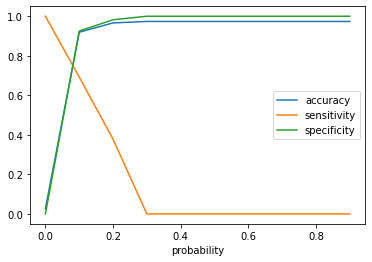

In [79]:
#plotting accuracy, sensitivity and specificity for different probability values
cutoff_df.plot('probability', ['accuracy', 'sensitivity', 'specificity'])
plt.show()

From the above graph, we can see that optimum cutoff point is at 0.1 where accuracy, sensitivity and specificity are same

In [80]:
#creating a prediction column with optimum threshhold as 0.1
y_pred_train_final['prediction'] = y_pred_train_final['churn_prob'].map(lambda x: 1 if x > 0.1 else 0)
y_pred_train_final.head()

,custid,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,prediction
98077,98077,0,4.418596e-10,1,0,0,0,0,0,0,0,0,0,0
40036,40036,0,8.840676e-06,1,0,0,0,0,0,0,0,0,0,0
85637,85637,0,2.487922e-05,1,0,0,0,0,0,0,0,0,0,0
9533,9533,0,1.672677e-02,1,0,0,0,0,0,0,0,0,0,0
27502,27502,0,8.129265e-04,1,0,0,0,0,0,0,0,0,0,0


In [81]:
conf = metrics.confusion_matrix(y_pred_train_final['churn'], y_pred_train_final.prediction)
print(conf)

[[19882  1605]
 [  179   403]]


In [82]:
print('Accuracy-', metrics.accuracy_score(y_pred_train_final['churn'], y_pred_train_final.prediction))
print('Sensitivity-', metrics.recall_score(y_pred_train_final['churn'], y_pred_train_final.prediction))
print('Specificity-', conf[0,0] / (conf[0,0] + conf[0,1]))

Accuracy- 0.9191626263083964
Sensitivity- 0.6924398625429553
Specificity- 0.9253036719877135


### Plotting the ROC curve to find out tradeoff between sensitivity and specificity

In [83]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

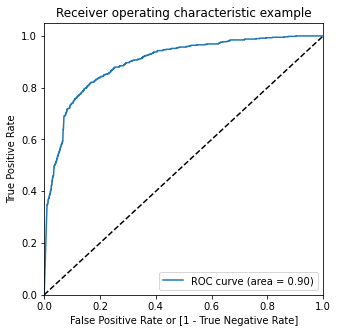

In [84]:
draw_roc(y_pred_train_final['churn'], y_pred_train_final['churn_prob'])

From the above graph, we can see that area under ROC curve is 0.90

### Testing the model on the test set

In [85]:
X_test_sm = sm.add_constant(X_test[rfe_cols])


y_pred_test_final = pd.DataFrame({
    'custid' : X_test.index,
    'churn' : y_test.values,
    'churn_prob' : log_reg.predict(X_test_sm)
})

y_pred_test_final['prediction'] = y_pred_test_final['churn_prob'].map(lambda x: 1 if x > 0.1 else 0)
y_pred_test_final.head()


,custid,churn,churn_prob,prediction
41280,41280,0,1.217089e-05,0
51831,51831,0,1.160746e-02,0
74908,74908,0,8.025381e-08,0
41153,41153,0,1.078615e-01,1
23744,23744,0,6.435252e-05,0


In [86]:
conf = metrics.confusion_matrix(y_pred_test_final['churn'], y_pred_test_final.prediction)
print(conf)

[[4916  429]
 [  56  117]]


In [87]:
print('Accuracy-', metrics.accuracy_score(y_pred_test_final['churn'], y_pred_test_final.prediction))
print('Sensitivity-', metrics.recall_score(y_pred_test_final['churn'], y_pred_test_final.prediction))
print('Specificity-', conf[0,0] / (conf[0,0] + conf[0,1]))

Accuracy- 0.9121058354476259
Sensitivity- 0.6763005780346821
Specificity- 0.9197380729653882


#### Results using Logistic Regression model without PCA
- Training Dataset
    - Accuracy - 0.92
    - Sensitivity - 0.70
    - Precision - 0.93
- Test Dataset
    - Accuracy - 0.91
    - Sensitivity - 0.68
    - Specificity - 0.92

### Business Recommendation

Below are the top recommended variables suggested in Logistic Regression model - 
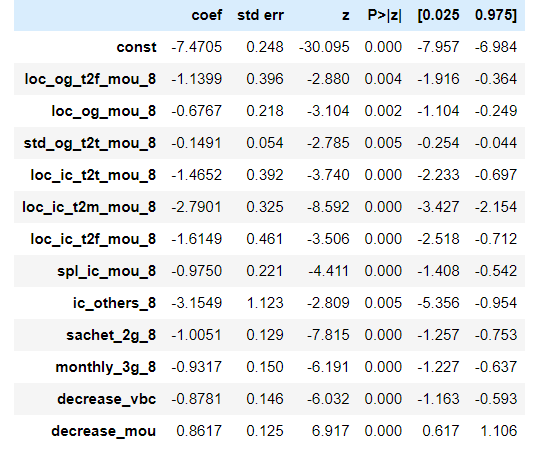

From the above summary, we can see that many variables are inversely related with churn probability. Moreover `ic_others_8` variables has highest negative coefficient i.e. if incoming calls are reduced in August, then customer is more likely to churn in September

### Recommendations to business

- Target the customer whose local outgoing minutes of usage with fixed line(loc_og_t2f_mou_8), local STD minutes of usage within the same operator(std_og_t2t_mou_8) and local outgoing minutes of usage(loc_og_mou_8) reduced during the action period.
- Focus on the customers whose incoming minutes of usage within the same operator(loc_ic_t2t_mou_8), local incoming minutes of usage to other operator mobile(loc_ic_t2m_mou_8) and local incoming minutes of usage to fixed lines(loc_ic_t2f_mou_8) reduced during the action period
- Target the customers whose special incoming minutes of usage and incoming calls reduced during the action period
- Customers whose monthly 3G recharge is reduced in August, they are more likely to churn
- Customers whose value based cost in increased in action phase for churning customers
- Target customers whose minutes of usage are reduced in action phase

### Important predictors for churning and non-churning customers

In [88]:
df_churn = df[df['churn'] == 1].copy()
df_non_churn = df[df['churn'] == 0].copy()

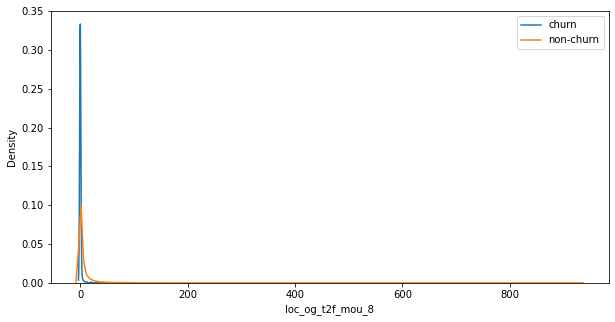

In [91]:
#plotting loc_og_t2f_mou_8 for churn and non-churn customers
plt.figure(figsize=(10, 5))
sns.distplot(df_churn['loc_og_t2f_mou_8'], label='churn', hist=False)
sns.distplot(df_non_churn['loc_og_t2f_mou_8'], label='non-churn', hist=False)
plt.legend()
plt.show()

From the above graph, we can see that local minutes of usage for outgoing calls to fixed lines are mostly concentrated around zero in August for churning customers

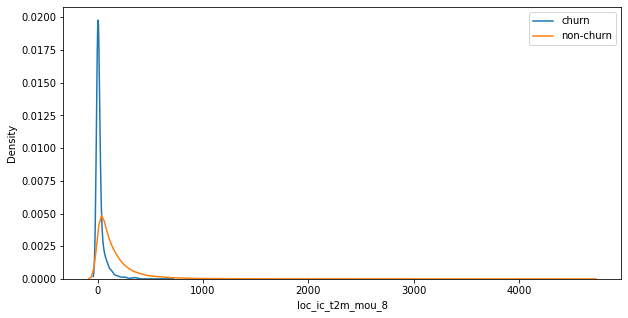

In [92]:
#plotting 'loc_ic_t2m_mou_8' for churn and non-churn customers
plt.figure(figsize=(10, 5))
sns.distplot(df_churn['loc_ic_t2m_mou_8'], label='churn', hist=False)
sns.distplot(df_non_churn['loc_ic_t2m_mou_8'], label='non-churn', hist=False)
plt.legend()
plt.show()

From the above graph, we can see that local minutes of usage for incoming calls to other mobile operators in August are mostly concentrated around zero for churning customers